In [1]:
!pip install pyspark
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark import SparkConf

spark = SparkSession.builder.appName("Test_spark").master("local[*]").getOrCreate()
sqlCtx = SQLContext(sparkContext=spark.sparkContext, sparkSession=spark)
spark

     |████████████████████████████████| 212.4MB 67kB/s 
     |████████████████████████████████| 204kB 15.5MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.2-py2.py3-none-any.whl size=212880768 sha256=53188754f165160d5eb7693e810441a21129463630a1ca15a97d244cc5142e47
  Stored in directory: /root/.cache/pip/wheels/40/1b/2c/30f43be2627857ab80062bef1527c0128f7b4070b6b2d02139
Successfully built pyspark


In [2]:
from google.colab import files
uploaded = files.upload()

Saving glass.csv to glass.csv


In [4]:
# Lectura del fichero
df = sqlCtx.read.load('glass.csv', format='com.databricks.spark.csv', header='true', inferSchema='true')
df.count()

214

In [7]:
df.toPandas()[:5]

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [8]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

# Construimos el vector
featuresUsed = ['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe', 'Type']
assembler = VectorAssembler(inputCols=featuresUsed, outputCol="features_unscaled")
assembled = assembler.transform(df)

In [9]:
from pyspark.ml.feature import StandardScaler

# Contrsuimos el modelo
scaler = StandardScaler(inputCol="features_unscaled", outputCol="features", withMean=True , withStd=True)
scalerModel = scaler.fit(assembled)
scalerData = scalerModel.transform(assembled)

In [29]:
#utils library
from itertools import cycle, islice
from math import sqrt
from numpy import array
from pandas.plotting import parallel_coordinates
from pyspark.ml.clustering import KMeans as KM
from pyspark.mllib.linalg import DenseVector
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
 
# Cálculo del coste computancional
def computeCost(featuresAndPrediction, model):
    allClusterCenters = [DenseVector(c) for c in model.clusterCenters()]
    arrayCollection = featuresAndPrediction.rdd.map(array)
 
    def error(point, predictedCluster):
        center = allClusterCenters[predictedCluster]
        z = point - center
        return sqrt((z*z).sum())
 
    return arrayCollection.map(lambda row: error(row[0], row[1])).reduce(lambda x, y: x + y)
 
# Gráfico del error acumulado
def elbow(elbowset, clusters):
    wsseList = []
    ## Comienza a realizar N K-Means
    for k in clusters:
        print("Training for cluster size {}".format(k))
        kmeans = KM(k = k, seed = 1)
        model = kmeans.fit(elbowset)
        transformed = model.transform(elbowset)
        featuresAndPrediction = transformed.select("features", "prediction")
        
        W = computeCost(featuresAndPrediction, model)
        print("......................WSSE = {}".format(W))
        
        wsseList.append(W)
    return wsseList
 
# Plotea la gráfica
def elbow_plot(wsseList, clusters):
    wsseDF = pd.DataFrame({'WSSE' : wsseList, 'k' : clusters })
    wsseDF.plot(y='WSSE', x='k', figsize=(15,10), grid=True, marker='o')
 
def pd_centers(featuresUsed, centers):
    colNames = list(featuresUsed)
    colNames.append('prediction')
 
    # Zip with a column called 'prediction' (index)
    Z = [np.append(A, index) for index, A in enumerate(centers)]
 
    # Convert to pandas for plotting
    P = pd.DataFrame(Z, columns=colNames)
    P['prediction'] = P['prediction'].astype(int)
    return P
 
def parallel_plot(data, P):
    my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(P)))
    plt.figure(figsize=(15,8)).gca().axes.set_ylim([-7,+14])
    parallel_coordinates(data, 'prediction', color = my_colors, marker='o')

In [13]:
clusters = range(2,25)
wsseList = elbow(scalerData,clusters)

Training for cluster size 2
......................WSSE = 482.4439709210644
Training for cluster size 3
......................WSSE = 428.1182745637464
Training for cluster size 4
......................WSSE = 409.13147743763363
Training for cluster size 5
......................WSSE = 391.472935733386
Training for cluster size 6
......................WSSE = 355.52721820978275
Training for cluster size 7
......................WSSE = 331.43061964831327
Training for cluster size 8
......................WSSE = 315.1646254596065
Training for cluster size 9
......................WSSE = 336.66523224665383
Training for cluster size 10
......................WSSE = 300.7711971328286
Training for cluster size 11
......................WSSE = 296.9786076998319
Training for cluster size 12
......................WSSE = 283.1273344642336
Training for cluster size 13
......................WSSE = 274.0593461433402
Training for cluster size 14
......................WSSE = 273.63998434849947
Training for clu

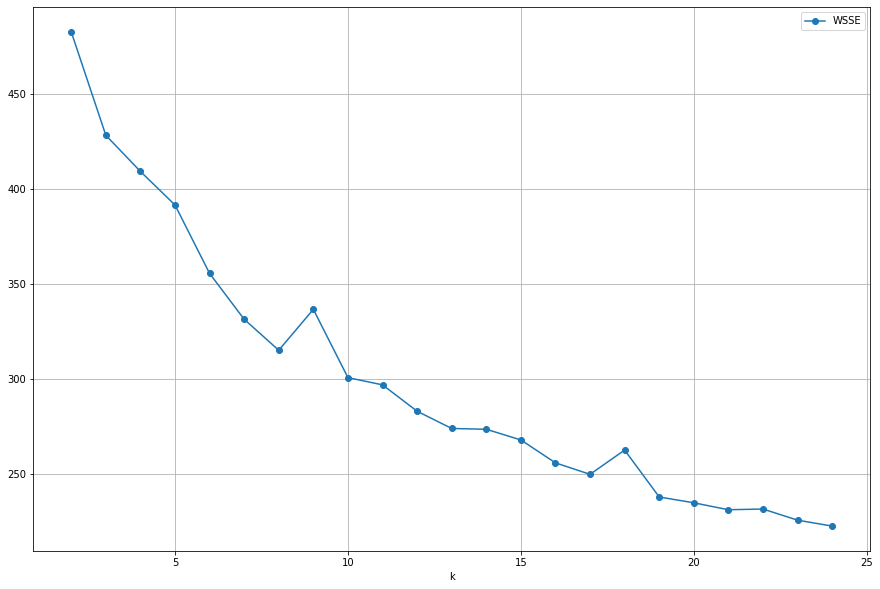

In [14]:
elbow_plot(wsseList, clusters)

In [25]:
from pyspark.ml.clustering import KMeans
from itertools import cycle, islice
from pandas.plotting import parallel_coordinates
from pyspark.mllib.linalg import DenseVector
import matplotlib.pyplot as plt

scaledDataFeat = scalerData.select("features")
scaledDataFeat.persist()
kmeans = KMeans(k=10, seed=1)
model = kmeans.fit(scaledDataFeat)
transformed = model.transform(scaledDataFeat)
centers = model.clusterCenters()
centers

[array([-0.18812764,  0.15021041,  0.62828036, -0.12846227, -0.33589408,
         0.02417147, -0.40577172, -0.3107963 , -0.3535068 , -0.40751113]),
 array([ 2.41518226, -1.91384235, -1.6635605 , -0.560632  , -0.15613613,
        -0.3430321 ,  3.34916139, -0.35205138,  0.16753084, -0.13327408]),
 array([ 4.68397026, -2.31795521, -1.86114678,  0.21049439, -3.4419328 ,
        -0.22547978,  4.0670507 ,  2.81556525,  2.0832652 , -0.37094619]),
 array([-0.56718304,  1.38641269, -1.5337621 ,  1.59993136,  0.31104329,
        -0.36177233, -0.44861226,  2.05839128, -0.43683774,  1.97056422]),
 array([-0.44794101, -0.56462013,  0.49590537, -0.08858655,  0.49574948,
         0.20202259, -0.40517319, -0.34727908, -0.4963662 , -0.54819318]),
 array([-0.20415535, -0.43017084,  0.47146077, -0.24045003,  0.16774033,
         0.08074037, -0.22051013, -0.29401433,  1.74605686, -0.4388525 ]),
 array([ 1.30940488,  0.44523209,  0.71160156, -1.33652727, -1.17117033,
        -0.58908883,  0.57162743, -0.35

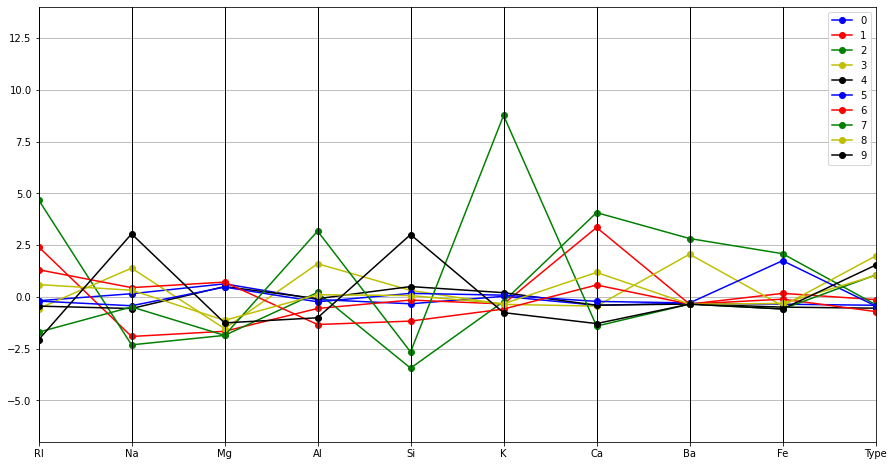

In [30]:
P = pd_centers(featuresUsed, centers)
parallel_plot(P, P)

In [31]:
df_join = scalerData.join(transformed, on=['features'], how='inner')
df_join.show()

+--------------------+-------+-----+----+----+-----+----+----+---+----+----+--------------------+----------+
|            features|     RI|   Na|  Mg|  Al|   Si|   K|  Ca| Ba|  Fe|Type|   features_unscaled|prediction|
+--------------------+-------+-----+----+----+-----+----+----+---+----+----+--------------------+----------+
|[0.87082584738783...|1.52101|13.64|4.49| 1.1|71.78|0.06|8.75|0.0| 0.0|   1|[1.52101,13.64,4....|         6|
|[-0.2487502323371...|1.51761|13.89| 3.6|1.36|72.73|0.48|7.83|0.0| 0.0|   1|[1.51761,13.89,3....|         0|
|[-0.7196307599860...|1.51618|13.53|3.55|1.54|72.99|0.39|7.78|0.0| 0.0|   1|[1.51618,13.53,3....|         4|
|[-0.2322858782234...|1.51766|13.21|3.69|1.29|72.61|0.57|8.22|0.0| 0.0|   1|[1.51766,13.21,3....|         0|
|[-0.3113147779687...|1.51742|13.27|3.62|1.24|73.08|0.55|8.07|0.0| 0.0|   1|[1.51742,13.27,3....|         4|
|[-0.7920739180859...|1.51596|12.79|3.61|1.62|72.97|0.64|8.07|0.0|0.26|   1|[1.51596,12.79,3....|         5|
|[-0.3080219071460.